In [131]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import tqdm

# Visualize the datasets and manage the dataset

In [132]:
edges = pd.read_csv("wikigraph_reduced.csv", sep="\t", usecols = ["0", "1"])
edges.columns = ["source", "dest"]
edges.head()

,source,dest
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


Read the pages names.

In [133]:
pages_names = pd.read_csv("wiki-topcats-page-names.txt", names=["node name"])
pages_names

pages_names['node'] = [s.split()[0] for s in list(pages_names['node name']) ]
pages_names['name'] = [' '.join(s.split()[1:]) for s in list(pages_names['node name'])]

pages_names = pages_names.set_index("node").drop('node name', axis=1)
pages_names

,name
node,
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt


Read each line of the "wiki-topcats-categories.txt" and create the dataset

In [134]:
categories = pd.read_csv("wiki-topcats-categories.txt", sep=";", names = ["Category", "Pages List"])
categories["Category"] = categories.Category.apply(lambda x: x[9:])
categories["Pages List"] = categories["Pages List"].apply(lambda x: x.split())
categories

,Category,Pages List
0,Buprestoidea,"[301, 302, 303, 304, 305, 306, 307, 308, 309, ..."
1,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
2,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
3,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
4,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."
...,...,...
17359,British_science_fiction_novels,"[16110, 24545, 39814, 67923, 108629, 108630, 1..."
17360,Television_soundtracks,"[1117, 110192, 110376, 110377, 110380, 110395,..."
17361,Diptera_of_North_America,"[279, 280, 283, 31110, 31129, 31133, 31138, 31..."
17362,Diptera_of_Asia,"[279, 31129, 31133, 31134, 31135, 31136, 31137..."


You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.

In [135]:
cats = list(categories["Category"])
pages_list = list(categories["Pages List"])

create a vocabulary in order to create the clean categories without replicates.

In [136]:
nodes = {}
for i, list_pages in enumerate(pages_list):
    for node in list_pages:
        if node not in nodes:
            nodes[node] = []
        nodes[node].append(i)

Choose uniformly at random a category where the page will be belong, then create the dictionary.

Remove also the categories that haven't any node in the graph.

In [137]:
sources = set(edges["source"])
dests = set(edges["dest"])
red_nodes = sources.union(dests)

In [138]:
import random

nodes2 = defaultdict(list)
for node in nodes.keys():
    cat = random.sample(nodes[node], 1)[0]
    if int(node) in red_nodes:
        nodes2[cat].append(node)
    # else:
        # drop in the dataframe pages_names the useless node not present in the graph  

In [139]:
new_categories = pd.DataFrame()
new_categories['category'] = nodes2.keys()
new_categories['pages list'] = nodes2.values()

def set_category(x, categories):
    return categories.loc[x, "Category"]
    
new_categories["category"] = new_categories.category.apply(lambda x: set_category(x, categories)) # set the category not the integer value
new_categories

,category,pages list
0,Yeovil_Town_F.C._players,"[76871, 83975, 727951, 84640, 78014, 79597, 78..."
1,Huddersfield_Town_F.C._players,"[79069, 84396, 74402, 482810, 76945, 80654, 81..."
2,Worcester_City_F.C._players,"[79139, 83705, 84298, 89385, 1445606]"
3,Association_football_midfielders,"[79143, 737956, 738199, 27588, 27200, 27553, 2..."
4,England_youth_international_footballers,"[80237, 82696, 82790, 82883, 80645, 84208, 848..."
...,...,...
5241,Nahuatl_words_and_phrases,[1678297]
5242,German_lugers,[1699804]
5243,People_of_the_Chechen_wars,"[1706096, 1706098]"
5244,"Alumni_of_King's_College,_Cambridge",[1770965]


# RQ1

Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them.

In [140]:
import networkx as nx

create the graph, first we consider if the edges dataframe contents a graph directed or not..

In [141]:
def isDirected(edges):
    if len(set(list(edges['source'])).intersection(set(list(edges['dest'])))) > 0:
        return "directed"
    else:
        return "undirected"

In [142]:
if isDirected(edges) == "directed":
    G = nx.DiGraph(directed=True)
else:
    G = nx.Graph()

In [143]:
sources = list(edges['source'])
dests = list(edges['dest'])

for i in range(len(edges)):
    G.add_node(sources[i], name = pages_names.loc[str(sources[i]), 'name']) # source
    G.add_node(dests[i], name = pages_names.loc[str(dests[i]), 'name']) # dest
    
    G.add_edge(sources[i], dests[i], weight=1)

In [144]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 98343\nNumber of edges: 483094\nAverage in degree:   4.9123\nAverage out degree:   4.9123'

In [145]:
print(f"The number of nodes is: {G.number_of_nodes()} and the number of edges is: {G.number_of_edges()}")

The number of nodes is: 98343 and the number of edges is: 483094


In [146]:
if nx.is_directed(G):
    print("The Graph is directed")
else:
    print("The Graph is undirected")

The Graph is directed


for the directed graph to understand if the graph is sparse or not, we should use this formula:

$D = \frac{|E|}{|V|(|V|-1)}$

a dense graph is a graph in which the number of edges is close to the maximal number of edges.

In [147]:
# we can use also nx.density(G)
D = (G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
print(f"The graph density is: {D}, so the graph is sparse")

The graph density is: 4.9951571365597335e-05, so the graph is sparse


the average of link per article is.. (considering the **degree** of each node)

In [148]:
degrees = dict(G.degree())
sum(degrees.values())/float(len(G))

9.824674862471147

the result presents above include in_degree and out_degree of a graph. We can consider also the in_degree and out_degree formula. But, you could use also the native function of networkx

In [149]:
indegree = sum(dict(G.in_degree()).values())/float(len(G))
outdegree = sum(dict(G.out_degree()).values())/float(len(G))
print(f"the indegree = {indegree} and the outdegree = {outdegree}")

the indegree = 4.912337431235573 and the outdegree = 4.912337431235573


Visualize the **nodes degree distribution**

In [20]:
degrees = dict(nx.degree(G))

NodeDistro = pd.DataFrame()

NodeDistro['node'] = degrees.keys()
NodeDistro['degree'] = degrees.values()

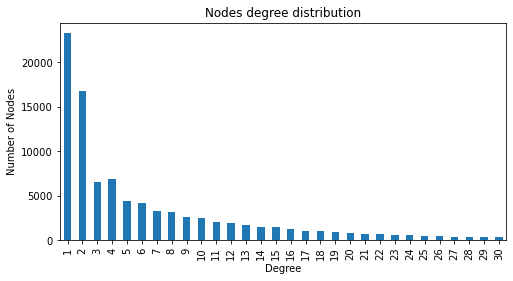

In [21]:
NodeDistro.groupby([NodeDistro.degree]).node.count().head(30).plot.bar(figsize=(8,4))
    
#create the plot
plt.grid()
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Nodes degree distribution')
plt.grid(b=None)
plt.show()

# RQ2

In [22]:
sources = list(edges['source'])
dests = list(edges['dest'])

choose in input a page v.

In [23]:
v = int(input("Choose a node to start the BFS: "))
v

Choose a node to start the BFS: 95


95

A number of clicks d.

In [24]:
d = int(input("Choose a number of clicks: "))
d

Choose a number of clicks: 2


2

In [25]:
def initialization(G):
    nodes = list(G.nodes()) # return the list of nodes
    dist = [float('inf') for x in range(len(nodes))] # initialize the distance to inf in order to avoid the distance = 0, that means other thing
    visited = [False for x in range(len(nodes))] # initialize the visited = False
    return nodes, dist, visited

def BFS(G, v, d):
    nodes, dist, visited = initialization(G)
    
    queue = [] # create queue for BFS
    
    # start BFS
    queue.append(v)
    visited[nodes.index(v)] = True
    dist[nodes.index(v)] = 0
    
    i = 0
    while queue and i <= d:
        s = queue.pop(0)
        
        for neigh in nx.neighbors(G, s):
            if visited[nodes.index(neigh)] == False:
                visited[nodes.index(neigh)] = True
                dist[nodes.index(neigh)] = dist[nodes.index(s)] + 1
                queue.append(neigh)
        i+=1
    dist = list(filter(lambda a: a != float('inf'), dist))
        
    return dist, nodes

In [26]:
dist, nodes = BFS(G, v, d)
indices = [i for i, x in enumerate(dist) if x == d]
nodes = [pages_names.loc[str(x), "name"] for i, x in enumerate(nodes) if i in indices]
print(f"the set of all pages that you can achieve with {d} are {nodes}")

the set of all pages that you can achieve with 2 are ['Born Innocent (Redd Kross album)', 'Beyond the Valley of the Dolls', 'Linda Blair', 'Stu Phillips (composer)', 'Robert Tasker', 'Humphrey Bogart']


# RQ3

returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

According to the professors request, I prefer using the betweeness centrality in order to have the most centered node in the graph.

In [74]:
ctg = list(new_categories["category"])
pg_lst = list(new_categories["pages list"])

union_lst = [ [x, list(map(int,pg_lst[i]))] for i, x in enumerate(ctg) ]

my_dict = {x[0]: x[1] for x in union_lst}

Choose randomly the category in order to find the minimum number of clicks to achieve all nodes in one category.

In [75]:
cat = random.sample(my_dict.keys(), 1)[0]
cat

'UK_MPs_1974'

Consider the subgraph of G interesting to the selected category chose.

In [76]:
new_cat = G.subgraph(my_dict[cat])
print(f"the number of pages are {len(new_cat)} and the number of edges are {len(new_cat.edges)}")

the number of pages are 49 and the number of edges are 5


Considering the node most centered in the graph is.. with the in-degree centrality.

In [77]:
indegree_node = { node: new_cat.in_degree(node) if new_cat.in_degree(node) != 0 else float("inf") for node in new_cat.nodes }
indegree_node = dict(sorted(indegree_node.items(), key=lambda item: item[1]))
indegree_node

{538636: 1,
 540368: 1,
 539611: 1,
 539745: 1,
 539887: 1,
 540291: inf,
 538245: inf,
 539916: inf,
 539532: inf,
 543250: inf,
 539027: inf,
 540564: inf,
 540692: inf,
 539929: inf,
 541084: inf,
 539168: inf,
 539173: inf,
 540581: inf,
 540073: inf,
 538411: inf,
 540335: inf,
 539318: inf,
 540473: inf,
 535353: inf,
 538555: inf,
 540988: inf,
 540736: inf,
 542659: inf,
 539079: inf,
 540999: inf,
 539979: inf,
 538964: inf,
 538838: inf,
 540632: inf,
 535515: inf,
 540383: inf,
 540003: inf,
 540004: inf,
 538729: inf,
 538477: inf,
 538735: inf,
 540655: inf,
 540274: inf,
 540531: inf,
 540915: inf,
 539000: inf,
 542458: inf,
 538747: inf,
 540798: inf}

In [78]:
min_val = min(indegree_node.items(), key=lambda x: x[1])[1]
min_values = [ x for x in indegree_node if indegree_node[x] == min_val ]
for v in min_values:
    print(f"the most centered node is {v}")

the most centered node is 538636
the most centered node is 540368
the most centered node is 539611
the most centered node is 539745
the most centered node is 539887


Call and calculate the BFS for all nodes.

In [79]:
# call different_bfs() and create the matrix of distances from v to all edges, so..
dict_allbfs = { k: { x: float("inf")  for x in my_dict[cat] } for k in my_dict[cat] }

In [95]:
for node in tqdm(dict_allbfs):
    distances = different_bfs(new_cat, node)
    for val in distances:
        dict_allbfs[node][val] = distances[val]

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 24589.72it/s]


Now we create the new graph directed and well weighted.

In [96]:
G_cat_W = nx.DiGraph(directed=True)

for node in dict_allbfs:
    G_cat_W.add_node(node, name = pages_names.loc[str(node), 'name'])
    for edge in dict_allbfs[node]:
        if (dict_allbfs[node][edge] != float("inf")) and (dict_allbfs[node][edge] != 0):
            G_cat_W.add_edge(node, edge, weight=dict_allbfs[node][edge])

In [97]:
nx.get_edge_attributes(G_cat_W,'weight')

{(539611, 539887): 1,
 (539887, 539611): 1,
 (538964, 539745): 1,
 (539027, 540368): 1,
 (540003, 538636): 1}

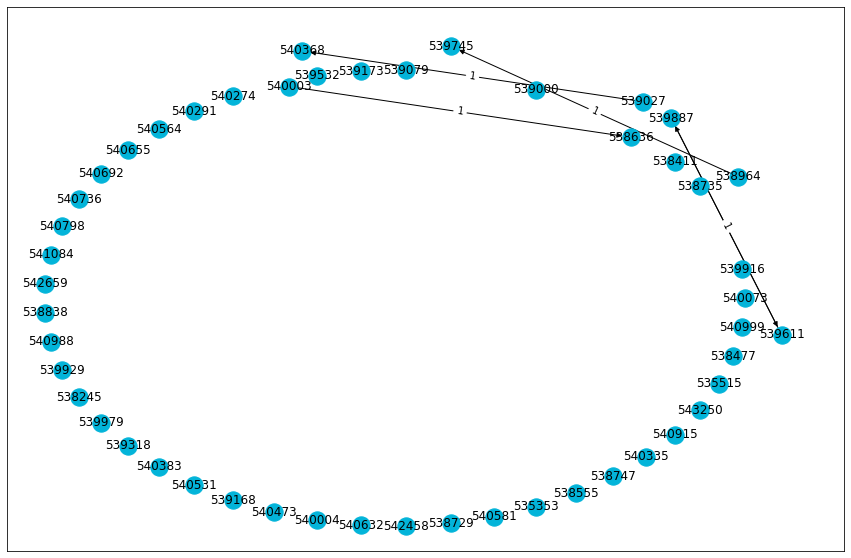

In [98]:
labels = nx.get_edge_attributes(G_cat_W,'weight')
pos=nx.kamada_kawai_layout(G_cat_W) # pos = nx.nx_agraph.graphviz_layout(G)
plt.figure(3,figsize=(15, 10))
nx.draw_networkx(G_cat_W, pos, node_color='#03b4d9')
nx.draw_networkx_edge_labels(G_cat_W, pos, with_labels=True, edge_labels=labels)
plt.show()

In [99]:
def nearest_neigh(G, v):
    queue = []
    queue.append(v)
    
    explored = {}
    explored[v] = 0
    while queue:
        s = queue.pop(0)
        
        near_dists = []
        for neigh in nx.neighbors(G_cat_W, s):
            near_dists.append([neigh, G[s][neigh]['weight']])
        
        if near_dists:
            near_neigh = sorted(near_dists, key = lambda x: x[1])[0][0]
            if near_neigh not in explored:
                explored[neigh] = G[s][neigh]['weight']
                queue.append(near_neigh)
    
    if len(explored) != len(G.nodes):
        return "we can't achieve all pages, so.. NOT POSSIBLE!"
    else:
        return f"we need a minimum of {sum(explored.values())} steps to achieve all pages"

In [100]:
for v in min_values:
    expl = nearest_neigh(G_cat_W, v)
    print(f"Start with the source {v}.. we need, maybe.. {expl}")

Start with the source 538636.. we need, maybe.. we can't achieve all pages, so.. NOT POSSIBLE!
Start with the source 540368.. we need, maybe.. we can't achieve all pages, so.. NOT POSSIBLE!
Start with the source 539611.. we need, maybe.. we can't achieve all pages, so.. NOT POSSIBLE!
Start with the source 539745.. we need, maybe.. we can't achieve all pages, so.. NOT POSSIBLE!
Start with the source 539887.. we need, maybe.. we can't achieve all pages, so.. NOT POSSIBLE!


# RQ5

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

In [82]:
c0 = str(input("Insert the first category: "))
c0

Insert the first category: English_footballers


'English_footballers'

In [83]:
def different_bfs(G, v):
    queue = [] # create queue for BFS
    
    # start BFS
    queue.append(v)
    distances = {}
    distances[v] = 0
    
    while queue:
        s = queue.pop(0)
        
        for neigh in nx.neighbors(G, s):
            if neigh not in distances:
                distances[neigh] = distances[s] + 1
                queue.append(neigh)
                
    return distances

In [84]:
import statistics
from tqdm import tqdm

ctg = list(new_categories["category"])
pg_lst = list(new_categories["pages list"])
union_lst = [ [x, list(map(int,pg_lst[i]))] for i, x in enumerate(ctg) ]
my_dict = {x[0]: x[1] for x in union_lst}

list_c0 = my_dict[c0]
my_distances_bfs = {}
for node in tqdm(list_c0):
    my_distances_bfs[node] = different_bfs(G, node)

medians = []
for i, ct in tqdm(enumerate(ctg)):
    values_lists = []
    if ct != c0: 
        list_c_i = my_dict[ct]
        for node_x in list_c0:
            for node_y in list_c_i: 
                if node_y in my_distances_bfs[node_x]:
                    values_lists.append(my_distances_bfs[node_x][node_y])
                else:
                    values_lists.append(float("inf"))
        medians.append(statistics.median(values_lists))

100%|████████████████████████████████████████████████████████████████████████████████| 878/878 [02:31<00:00,  5.78it/s]
5219it [00:50, 103.75it/s]


In [85]:
dists2 = medians.copy()

In [86]:
union_dist_idx = [ [i, int(x)] for i, x in enumerate(dists2) if x != float("inf") ]
union_dist_idx = sorted(union_dist_idx, key=lambda x: x[1])

In [87]:
distance_cat0 = pd.DataFrame()
distance_cat0["category"] = [ new_categories.loc[x[0], "category"] for x in union_dist_idx ]
distance_cat0["distance"] = [ x[1] for x in union_dist_idx ]
distance_cat0

,category,distance
0,Chelsea_F.C._players,4
1,UEFA_Euro_1992_players,4
2,Moroccan_footballers,5
3,Jewish_footballers,5
4,Jewish_American_scientists,5
...,...,...
2402,English-language_albums,15
2403,Members_of_the_United_States_House_of_Represen...,15
2404,Films_directed_by_Chuck_Jones,15
2405,Hapoel_Tel_Aviv_F.C._players,16


# RQ6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

In [150]:
import numpy as np

def PageRank(G, d = 0.85, max_iter = 100):
    probs_node = { x: 1 / len(G) for x in G.nodes }                                                                                             # create dict of uniform probs for each page
    out_degrees = { x: G.out_degree(x) if G.out_degree(x) != 0 else len(G) for x in G.nodes }                                                   # create dict of uniform out_degrees for each page and for a page with noone outlinks our choice is uniformly at all pages present, so consider the length of the graph 
    
    new_probs_node = probs_node.copy()                                                                                                          # save each new iteration considering always the old probabilities
                                                                                                                                                # the optimal way to choose the correct number of iterations
    for _ in tqdm(range(max_iter)):                                                                                                             # the algorithm iterate to achieve the best predictive socre  
        for p_x in new_probs_node:                                                                                                              # catch each page in order to update the probabilities                            
            ratios_sum = sum([ probs_node[neigh] / out_degrees[neigh] for neigh in nx.neighbors(G, p_x) ])                                      # increase the rank, check if the neighbors has outgoing links, if it not go forward to the next neighbor
            new_probs_node[p_x] = ( ( 1 - d ) / len(G) ) + ( d * ratios_sum )                                                                   # then update the value for the i-th node
        
            probs_node = new_probs_node.copy()
    
    return new_probs_node

In [151]:
# useful create a dict
refer_dt = categories[categories['Category'].isin(list(new_categories["category"]))]
lst_category = list(refer_dt['Category'])

lst_pages = [ set(map(int, lst_pg )) for lst_pg in list(refer_dt["Pages List"]) ]
my_dict = { cat: lst_pages[i] for i, cat in enumerate(lst_category) }

In [152]:
# create the new graph of categories and inserts the node as one category
new_G = nx.DiGraph(directed=True)
for cat in lst_category:
    new_G.add_node(cat)

In [153]:
# add edges
for x in tqdm(my_dict):
    for y in my_dict:
        if (x != y and len(my_dict[x].intersection(my_dict[y])) > 0):
            new_G.add_edge(x, y)

100%|██████████████████████████████████████████████████████████████████████████████| 5246/5246 [02:23<00:00, 36.59it/s]


Is a reasonable situation because the categories haven't any nodes connect.

In [154]:
len(new_G.edges)

1540986

In [155]:
tot_PageRank = PageRank(new_G)
sum(tot_PageRank.values())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


1.0000000000000024

In [156]:
sum(nx.pagerank(new_G, alpha = 0.85).values())

0.9999999999999971